<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_NLP/blob/main/Encoder_Decoder_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages and Modules Importation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import re
import urllib.request
import urllib3
import unicodedata
import zipfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install sentencepiece

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Masking, Dense

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 


# **Encoder-Decoder with RNN, RNN을 이용한 인코더-디코더**

## **Character-Level Neural Machine Translation(Seq2Seq), 문자 레벨 기계 변역기**  


---

- 기본적으로 Seq2Seq 모델은 **Input sequence와 Output Sequence의 길이가 다름**
- **성능이 좋은 기계 번역기를 구현**하기 위해서는 **방대한 양의 Dataset**이 필요
- 기계 번역기 학습을 위해 Train Dataset으로 **Parallel Corpus(병렬 코퍼스)가 필요**  
  *Parallel Corpus : 2개 이상의 언어가 병렬적으로 구성된 corpus*

In [2]:
http = urllib3.PoolManager()                            # Reference = https://pparkst.tistory.com/32
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = "fra-eng.zip"
path = os.getcwd()
zipfilename = os.path.join(path, filename)

with http.request("GET", url, preload_content=False) as r, open(zipfilename, "wb") as out_file:
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, "r") as zip_ref:
    zip_ref.extractall(path)

lines = pd.read_csv("fra.txt", names=["src", "tar", "lic"], sep="\t")
del lines["lic"]
print("Total Length of samples =", len(lines))
print()

lines = lines.loc[:, "src":"tar"]                               # Reference : https://bigdaheta.tistory.com/41
lines = lines[:60000]
lines.tar = lines.tar.apply(lambda x: "\t " + x + " \n")        # <sos>를 의미하는 \t와 <eos>를 의미하는 \n를 삽입

src_vocab = set()                                               # 문자 집합 생성
for line in lines.src:
    for char in line:
        src_vocab.add(char)
tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1
print("Source 문장의 char 집합 크기 =", src_vocab_size)
print("Target 문장의 char 집합 크기 =", tar_vocab_size)
print()

src_vocab = sorted(list(src_vocab))                                             # 각 문자에 index 부여
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_vocab = sorted(list(tar_vocab))
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])

encoder_input = []                                  # Encoder의 Input을 위한 Integer Encoding 수행
for line in lines.src:
    encoded = []
    for char in line:
        encoded.append(src_to_index[char])
    encoder_input.append(encoded)

decoder_input = []                                  # Decoder의 Input을 위한 Integer Encoding 수행
for line in lines.tar:
    encoded = []
    for char in line:
        encoded.append(tar_to_index[char])
    decoder_input.append(encoded)

decoder_target = []                                 # Decoder의 target값에는 <sos>에 해당하는 \t(index = 1)가 필요 없음
for line in lines.tar:
    timestep = 0
    encoded = []
    for char in line:
        if timestep > 0:
            encoded.append(tar_to_index[char])
        timestep += 1
    decoder_target.append(encoded)

max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print("Source Sentence Maximum =", max_src_len)
print("Target Sentence Maximum =", max_tar_len)

encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding="post")        # padding 작업 수행
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding="post")
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding="post")

encoder_input = to_categorical(encoder_input)                                           # One-Hot Encoding 수행
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

Total Length of samples = 197463

Source 문장의 char 집합 크기 = 79
Target 문장의 char 집합 크기 = 105

Source Sentence Maximum = 23
Target Sentence Maximum = 76


In [3]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)                   # Encoder의 hidden cell을 Decoder로 넘겨주기 위해 return_state=True로 설정
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)    # state_h = hidden state, state_c = cell state
encoder_states = [state_h, state_c]                                 # Decoder로 전달하게 될 Context Vector = [hidden state, cell state]

decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_softmax_layer = Dense(tar_vocab_size, activation="softmax")
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
print()
tf.keras.utils.plot_model(model, show_shapes=True)
print()

model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 79)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        344064      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

KeyboardInterrupt: ignored

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 79)]        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             344064    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 344,064
Trainable params: 344,064
Non-trainable params: 0
_________________________________________________________________


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 105)]  0           []                               
 

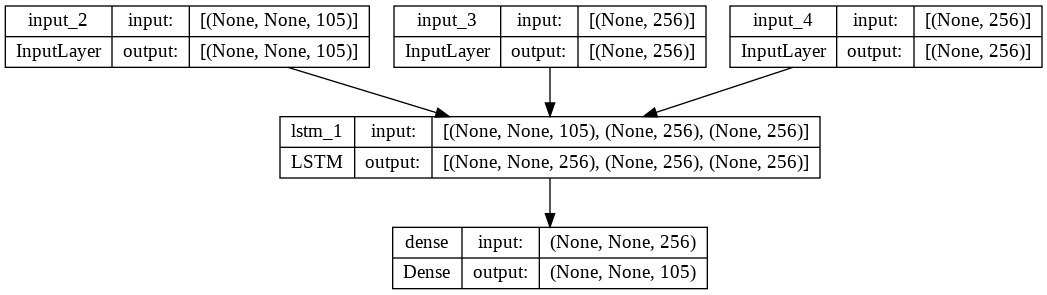

In [4]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()
print()
tf.keras.utils.plot_model(encoder_model, show_shapes=True)
print()

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()
print()
tf.keras.utils.plot_model(decoder_model, show_shapes=True)

In [5]:
index_to_src = dict((idx, char) for char, idx in src_to_index.items())
index_to_tar = dict((idx, char) for char, idx in tar_to_index.items())

def decode_seq(input_seq):
    states_value = encoder_model.predict(input_seq)     # 입력으로부터 Encoder의 states를 얻음

    target_seq = np.zeros((1, 1, tar_vocab_size))       # <sos>에 해당하는 One-Hot Vector 생성
    target_seq[0, 0, tar_to_index["\t"]] = 1.

    stop_cond = False
    decoded_sent = ""

    while not stop_cond:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)                                    # 이전 시점의 states_value를 현 시점의 초기 상태로 사용
        print(f"output_tokens.shape = {output_tokens.shape}, hidden.shape = {h.shape}, cell.shape = {c.shape}")

        sampled_token_index = np.argmax(output_tokens[0, -1, :])                # 예측 결과를 문자로 반환
        sampled_char = index_to_tar[sampled_token_index]

        decoded_sent += sampled_char                                            # 현 시점의 예측 문자를 예측 문장에 추가
        print(f"Decoded Sentence = {decoded_sent}")

        if sampled_char == "\n" or len(decoded_sent) > max_tar_len:             # <eos>에 도달하거나 max_len을 초과하면 stop
            stop_cond == True
        
        target_seq = np.zeros((1, 1, tar_vocab_size))                           # 현 시점의 예측 결과를 다음 시점의 input으로 사용하기 위한 저장
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]                                                   # 현 시점의 states_value를 다음 시점의 input으로 사용하기 위한 저장
    
    return decoded_sent

for seq_index in [3, 50, 100, 300, 1001]:                       # Input Sentence의 index들
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_seq(input_seq)

    print("Input Sentence =", lines.src[seq_index])
    print("Target Sentence =", lines.tar[seq_index][2:len(lines.tar[seq_index])-1])     # \t와 \n을 제외하고 출력
    print("Predict Sentence =", decoded_sentence[1:len(decoded_sentence)-1])            # \n을 제외하고 출력

    print(35 * "-")
    print()
    print()

1/1 [==============================] - 0s 458ms/step
output_tokens.shape = (1, 1, 105), hidden.shape = (1, 256), cell.shape = (1, 256)
Decoded Sentence =  
1/1 [==============================] - 0s 19ms/step
output_tokens.shape = (1, 1, 105), hidden.shape = (1, 256), cell.shape = (1, 256)
Decoded Sentence =  A
1/1 [==============================] - 0s 19ms/step
output_tokens.shape = (1, 1, 105), hidden.shape = (1, 256), cell.shape = (1, 256)
Decoded Sentence =  Al
1/1 [==============================] - 0s 25ms/step
output_tokens.shape = (1, 1, 105), hidden.shape = (1, 256), cell.shape = (1, 256)
Decoded Sentence =  All
1/1 [==============================] - 0s 26ms/step
output_tokens.shape = (1, 1, 105), hidden.shape = (1, 256), cell.shape = (1, 256)
Decoded Sentence =  Alle
1/1 [==============================] - 0s 24ms/step
output_tokens.shape = (1, 1, 105), hidden.shape = (1, 256), cell.shape = (1, 256)
Decoded Sentence =  Allez
1/1 [==============================] - 0s 25ms/step
ou

KeyError: ignored

## **Word-Level Neural Machine Translation(Seq2Seq), 단어 레벨 기계 변역기**

In [6]:
http = urllib3.PoolManager()                            # URL library 3 Reference = https://pparkst.tistory.com/32
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = "fra-eng.zip"
path = os.getcwd()
zipfilename = os.path.join(path, filename)

with http.request("GET", url, preload_content=False) as r, open(zipfilename, "wb") as out_file:
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, "r") as zip_ref:
    zip_ref.extractall(path)

num_samples = 33000

def unicode_to_ascii(string):                           # UnicodeData Reference = https://docs.python.org/ko/3/library/unicodedata.html
    return "".join(char for char in unicodedata.normalize("NFD", string) if unicodedata.category(char) != "Mn")     # 프랑스어 accent 삭제(ex. déjà diné -> deja dine)

def preproc_sent(sent):
    sent = unicode_to_ascii(sent.lower())                   # 문장 소문자화 및 정규화
    sent = re.sub(r"([?.!,¿])", r" \1", sent)              # 단어와 구두점 사이에 공백 삽입 
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)             # re.sub() 내의 문자들 제외하고 나머지는 모두 공백으로 변환
    sent = re.sub(r"\s+", " ", sent)                        # 다수의 공백을 1개의 공백으로 변환
    return sent

eng_sent = u"Have you had dinner?"
fra_sent = u"Avez-vous déjà diné?"
print("Before Preproc English Sentence =", eng_sent)
print("After Preproc English Sentence =", preproc_sent(eng_sent))
print("Before Preproc French Sentence =", fra_sent)
print("After Preproc French Sentence =", preproc_sent(fra_sent))

Before Preproc English Sentence = Have you had dinner?
After Preproc English Sentence = have you had dinner ?
Before Preproc French Sentence = Avez-vous déjà diné?
After Preproc French Sentence = avez vous deja dine ?


In [8]:
def load_preproc_data():                                                        # 모든 데이터들에 대한 전처리 + Teacher Forcing을 위한 3가지 list 생성
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):
            src_line, tar_line, _ = line.strip().split("\t")

            src_line = [word for word in preproc_sent(src_line).split()]
            tar_line = preproc_sent(tar_line)
            tar_line_in = [word for word in ("<sos>" + tar_line).split()]
            tar_line_out = [word for word in (tar_line + "<eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break
    
    return encoder_input, decoder_input, decoder_target

eng_sents_in, fra_sents_in, fra_sents_out = load_preproc_data()

eng_tokenizer = Tokenizer(filters="", lower=False)                              # Integer Encoding & padding 작업 수행
eng_tokenizer.fit_on_texts(eng_sents_in)
encoder_input = eng_tokenizer.texts_to_sequences(eng_sents_in)
encoder_input = pad_sequences(encoder_input, padding="post")

fra_tokenizer = Tokenizer(filters="", lower=False)
fra_tokenizer.fit_on_texts(fra_sents_in)
fra_tokenizer.fit_on_texts(fra_sents_out)
decoder_input = fra_tokenizer.texts_to_sequences(fra_sents_in)
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = fra_tokenizer.texts_to_sequences(fra_sents_out)
decoder_target = pad_sequences(decoder_target, padding="post")

print('Input of Encoder Shape =', encoder_input.shape)
print('Input of Decoder Shape =', decoder_input.shape)
print('Target of Decoder Shape =', decoder_target.shape)

Input of Encoder Shape = (33000, 8)
Input of Decoder Shape = (33000, 15)
Target of Decoder Shape = (33000, 15)


In [11]:
max_src_len = encoder_input.shape[1]
max_tar_len = decoder_input.shape[1]
print('source 문장의 최대 길이 =', max_src_len)
print('target 문장의 최대 길이 =', max_tar_len)
print()

src_vocab_size = len(eng_tokenizer.word_index) + 1
tar_vocab_size = len(fra_tokenizer.word_index) + 1
print("영어 단어 집합의 크기 = {:d}".format(src_vocab_size))
print("프랑스어 단어 집합의 크기 = {:d}".format(tar_vocab_size))

src_to_index = eng_tokenizer.word_index
index_to_src = eng_tokenizer.index_word
tar_to_index = fra_tokenizer.word_index
index_to_tar = fra_tokenizer.index_word

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

valid_size = int(33000 * 0.1)
encoder_input_train = encoder_input[:-valid_size]
decoder_input_train = decoder_input[:-valid_size]
decoder_target_train = decoder_target[:-valid_size]
encoder_input_test = encoder_input[-valid_size:]
decoder_input_test = decoder_input[-valid_size:]
decoder_target_test = decoder_target[-valid_size:]

source 문장의 최대 길이 = 8
target 문장의 최대 길이 = 15

영어 단어 집합의 크기 = 4672
프랑스어 단어 집합의 크기 = 9307


In [12]:
embedding_dim = 64
hidden_units = 64

encoder_inputs = Input(shape=(None,))
encoder_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)
encoder_mask = Masking(mask_value=0.0)(encoder_emb)
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_mask)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb_layer = Embedding(tar_vocab_size, hidden_units)
decoder_emb_1 = decoder_emb_layer(decoder_inputs)
decoder_mask = Masking(mask_value=0.0)(decoder_emb_1)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=encoder_states)
decoder_dense = Dense(tar_vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
print()
tf.keras.utils.plot_model(model, show_shapes=True)
print()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), epochs=50, batch_size=128)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     299008      ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     595648      ['input_6[0][0]']                
                                                                                            

KeyboardInterrupt: ignored

In [13]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()
print()
tf.keras.utils.plot_model(encoder_model, show_shapes=True)
print()

decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_emb_2 = decoder_emb_layer(decoder_inputs)
decoder_outputs_2, state_h2, state_c2 = decoder_lstm(decoder_emb_2, initial_state=decoder_states_inputs)
decoder_states_2 = [state_h2, state_c2]

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs_2] + decoder_states_2)
decoder_model.summary()
print()
tf.keras.utils.plot_model(decoder_model, show_shapes=True)
print()

def decode_seq(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_to_index["<sos>"]

    stop_cond = False
    decoded_sent = ""

    while not stop_cond:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        decoded_sent += sampled_char

        if sampled_char == "<eos>" or len(decoded_sent) > 50:
            stop_cond = True
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]
    
    return decoded_sent

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          299008    
                                                                 
 masking (Masking)           (None, None, 64)          0         
                                                                 
 lstm_2 (LSTM)               [(None, 64),              33024     
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
Total params: 332,032
Trainable params: 332,032
Non-trainable params: 0
_________________________________________________________________


Model: "model_5"
__________________________________

In [14]:
def seq_to_src(input_seq):          # 영어 Input Sentence의 Integer Sequence 형태를 문장으로 변환
    sent = ""
    for encoded_word in input_seq:
        if encoded_word != 0:
            sent += index_to_src[encoded_word] + " "
    return sent

def seq_to_tar(input_seq):          # 프랑스어 Predict Sentence의 Integer Sequence 형태를 문장으로 변환
    sent = ""
    for encoded_word in input_seq:
        if encoded_word != 0 and encoded_word != tar_to_index["<sos>"] and encoded_word != tar_to_index["<eos>"]:
            sent += index_to_tar[encoded_word] + " "
    return sent

for seq_index in [3,50,100,300,1001]:                                           # Train Data에 대해 Check
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_seq(input_seq)
  
  print("Input English Sentence :",seq_to_src(encoder_input_train[seq_index]))
  print("Target French Sentence :",seq_to_tar(decoder_input_train[seq_index]))
  print("Predict French Sentence :",decoded_sentence[1:-5])                     # 맨 앞에 space, 맨 뒤에 '<eos>'를 제외하고 출력
  print("-"*50)
print()
for seq_index in [3,50,100,300,1001]:                                           # Test Data에 대해 Check
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_seq(input_seq)
  
  print("Input English Sentence :",seq_to_src(encoder_input_test[seq_index]))
  print("Target French Sentence :",seq_to_tar(decoder_input_test[seq_index]))
  print("Predict French Sentence :",decoded_sentence[1:-5])                     # 맨 앞에 space, 맨 뒤에 '<eos>'를 제외하고 출력
  print("-"*50)

1/1 [==============================] - 0s 20ms/step
Input English Sentence : tom loved boston . 
Target French Sentence : <sos>tom a adore boston . 
Predict French Sentence : mede!<eos>came.<eos>le.<eos>caen.<eos>le.<eos
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
Input English Sentence : tom is happy . 
Target French Sentence : <sos>tom est content . 
Predict French Sentence : mede!<eos>came.<eos>le.<eos>caen.<eos>le.<eos
--------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Input English Sentence : they all scoffed . 
Target French Sentence : <sos>elles ont toutes raille . 
Predict French Sentence : meellea.<eos>caen.<eos>caen.<eos>le.<eos>caen.
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Input English Sentence : i disobeyed you . 
Target French Sentence : <sos>je vous ai desobei . 
Predict French Sentence : elleasuis.<